# Using MONAI to unlock clinically valuable insights from Digital Pathology

## Dealing with the size of Whole Slide Images

Today’s image acquisition devices, be they digital pathology slide scanners or lightsheet microscopes can generate a huge amount of data. This volume of data can make it very challenging to move around, save and load - let alone trying to ingest it into some sort of machine-learning or deep learning algorithm. 

The objective of this workshop is to introduce you to a few tools and techniques that can really help to deliver insights from this rich data without exhausting your system memory or taking eons to run. In fact, you may be surprised to see that outputs from MONAI can be used with the GPU accelerated RAPIDS API to turn some, previously unfeasible, analyses into near-real-time processes.

This workshop will mostly focus on digital pathology, but really, these techniques are very generic and could be applied to data from many different modalities.

Images or volumes can be saved in a variety of formats, some of which are generic and some of which are domain-specific. Additionally, images may be saved and loaded using formats that are based on open-standards or are proprietary to the manufacturers of the device used to capture the image.

The image that we will be using has come from the TCGA archive (https://www.cancer.gov/tcga) and was saved in the .svs format.


## Part 1 - Loading images

Images store a lot of information. Most commonly, images are composed of one or more channels of intensity values across 2 or 3 dimensions. In order to keep file sizes manageable, compression is usually employed. In some cases lossy compression is suitable but for other domains the images need to be lossless. This means that getting all of the pixel data from disk into computer memory can be quite an intense process and without the right tools, techniques and hardware, it can be a slow process. If you have an accelerator such as a GPU you may find that you are unable to utilize its full capabilities because you are unable to feed it data at a sufficiently high rate to keep it busy. 
This first section introduces a few tools that you can use to make best use of the resources available when it comes to loading the data. There are a few factors that come into play here:
The efficiency of the software algorithm
The speed of the machine-code that the software is compiled into
The number of CPU threads or processes used
The performance of the disk and networking that the data needs to traverse.
The speed of the CPU
Any hardware that the CPU supports to accelerate certain processes, such as AVX instructions

For the loading of a variety of biomedical imaging formats, the go-to software has been OpenSlide, which can load formats such as Aperio’s .svs format and many other tiff-based formats. First of all, let’s use OpenSlide to load up one of the images we have to get a feel for the latency involved in loading images at certain resolutions.


In [3]:
import openslide

# Load the image
slide = openslide.OpenSlide("data/tcga1.svs")

# Get the dimensions at level 0 (Full size)
width, height = slide.level_dimensions[0]

print("Full-Size Image Dimensions - Width = {}, Height = {}".format(width, height))

print("Level Downsamples - {}".format(slide.level_downsamples))

Full-Size Image Dimensions - Width = 87647, Height = 52434
Level Downsamples - (1.0, 4.000144748053987, 16.001674519945784, 32.011155571966384)


You should see that this image is 87647 x 52434, so that’s 4.6 billion pixels, with 3 color channels - just in one image. To put this into perspective, at a standard display resolution of 120 dots per inch, you’d need a 27 x 20 metre monitor to view this image at full resolution - that's about 2 tennis courts!

For this very reason, these types of image are often saved in formats that allow the image to be loaded at a lower resolution or provide a means of only loading a small sub-region of the image.

You should also notice that the image doesn't just contain the full resolution images but also a pyramid of resolutions (The Level Downsamples). In this case, along with the fill resolution images, there is also a 4x, 16x and 32x down-sampled version of the image. This permits viewers to load the image at lower resolutions for a broad overview and then the user can choose to zoom in to specific regions, using the higher resolution versions. The more levels that the pyramid contains, the smoother the zooming will be - at the cost of larger file sizes.

These lower resolution views can also be used for eliminating the background from processing by applying some sort of thresholding function to them and only selecting tiles for inference (or training) from the foreground regions.


![Pyramid](images/pyramid.png)

In [ ]:
import matplotlib.pyplot as plt

# get height and width at the lowest level resolution
w_thumbnail, h_thumbnail = slide.level_dimensions[slide.level_count-1]

# Load up the image data at the lowest resolution - to preview it
img = slide.read_region((0,0), slide.level_count-1,(w_thumbnail, h_thumbnail))
print("Reduced-Size Image Dimensions - Width = {}, Height = {}".format(w_thumbnail,h_thumbnail))

# Use Matplotlib to display the thumbnail view of the image
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.title('tcga1.svs')
plt.show()

The image displayed shows that many of the image pixels are actually not very informative. A lot of the image is white background, since this image contains a single tissue slice that is centred on the slide. 
Many image-processing pipelines will perform some sort of thresholding on the whole slide before doing more computationally intensive operations 

So let’s investigate the loading time for different resolutions of this image. In the cells below you will see some skeleton code which you need to flesh out to measure the time it takes to load the image at each of the resolutions that it contains. You should complete the code so that it plots the times for each resolution.

time_loading_at_resolution is a function that takes a slide and a reduction level and returns the time it takes to load the image data at that resolution

Check the [solution](solutions/solution1_1.py) if you get stuck


In [5]:
from timeit import default_timer as timer

def time_loading_at_resolution(slide, level): # slide 
    
    start = timer()

    w, h = slide.level_dimensions[level]
    print(w,h)
    img = slide.read_region((0,0), level,(w, h))

    end = timer()
    
    return end - start

When you have completed the code in the cell above and run it, you can test it by running the cell below. It should print out a range of load times for different resolutions

In [6]:
# Initialise a list to hold the loading times
times = [0] * (slide.level_count-1)

# Now call the timing function for a range of possible resolutions
for i in range(slide.level_count-1,0,-1):
    times[i-1] = time_loading_at_resolution(slide,i)
    print("Time at resolution reduction level {} = {}".format(i, times[i-1]))
    
print("Completed")

2738 1638
Time at resolution reduction level 3 = 0.23349112016148865
5477 3277
Time at resolution reduction level 2 = 1.1805710741318762
21911 13108
Time at resolution reduction level 1 = 35.66502108098939
Completed


If that works as expected, you should now have the load times in the array we created, which we can plot out by running the cell below. Note that we are not loading the image at full resolution (level 0) because that would take a long time.

<function matplotlib.pyplot.show(close=None, block=None)>

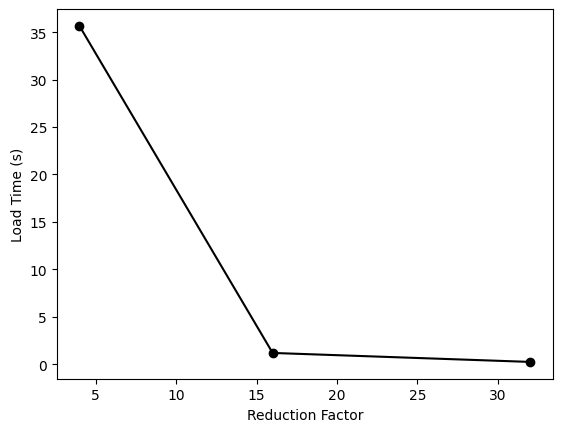

In [7]:
# Now plot the load times
downsample_factor = slide.level_downsamples[1:4]

plt.plot(downsample_factor, times, '-ok')
plt.xlabel("Reduction Factor")
plt.ylabel("Load Time (s)");

plt.show

So, because the number of pixels doubles for each doubling per dimension, the load time is quadratically related to the downsample level. We avoided loading the image at reduction level 0 because, according to this trend, it would take about several minutes at full resolution.

So, what can we do to reduce this load time? One technique that is often used to speed up many different types of operation is to use multi-threading. Multi-threading is a technique in which the process or program running your code spawns multiple sub-processes, known as threads, which can then operate in parallel, reducing the overall time to perform certain operations. In this case, we could get multiple threads loading different parts of the image. However, Python has a mechanism to prevent issues caused by concurrent execution (e.g. data races), known as the Global Interpreter (aka GIL) and this can prevent optimal performance.


## Introducing CuCIM

When dealing with much larger images, it is necessary to utilise as much of the available compute power than we have to run in parallel, otherwise it can be difficult to keep the GPU busy all the time. The problem we face here is that it is not just the Python GIL that we are working with but OpenSlide itself is not especially fast at this sort of operation. For this reason, the cuCIM library was recently added to the RAPIDS platform and is also used in MONAI. cuCIM offers similar capabilities to Openslide but has been optimised for the scenario we are exploring. The API is not exactly the same as OpenSlide, so you can see that, to do what we did before, we will need to amend the loading code slightly. Have a look at the code cell below to see how to get the image dimensions at a specific resolution and load the image.

N.B. When loading a specific region of interest at a reduction level > 0, you need to supply the x and y coordinates at the full resolution, whereas the width and height should be supplied at the reduced size. See the [documentation](https://docs.rapids.ai/api/cucim/stable/api.html#module-cucim.CuImage) for more details

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2738 1638


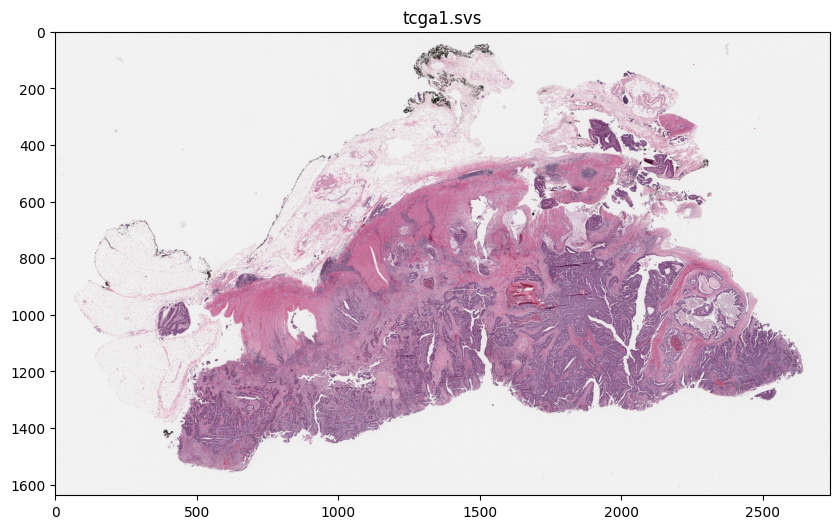

In [8]:
from cucim import CuImage

input_file = "data/tcga1.svs"
# load the image header
wsi = CuImage(input_file)

# Get the resolution meta data
sizes=wsi.metadata["cucim"]["resolutions"]
levels = sizes["level_count"]

# Get the dimensions at the lowest resolution level
wt = sizes["level_dimensions"][levels-1][0]
ht = sizes["level_dimensions"][levels-1][1]

# Load the image data at this resolution
wsi_thumb = wsi.read_region(location=(0,0), size=(wt,ht), level=levels-1)

plt.figure(figsize=(10,10))
plt.imshow(wsi_thumb)
plt.title('tcga1.svs')
print(wt,ht)
plt.show()

Now we can compare the performance of image loading using OpenSlide and cuCIM. In the code cell below add the necessary steps for cucim to load the image at the specified resolution ([solution](solutions/solution1_3.py))

In [9]:
from timeit import default_timer as timer

def time_loading_at_resolution(level, use_cucim):
    
    start = timer()

    if use_cucim:
        sizes=wsi.metadata["cucim"]["resolutions"]

        # Get the dimensions at the lowest resolution level
        wt = sizes["level_dimensions"][level][0]
        ht = sizes["level_dimensions"][level][1]
        wsi_thumb = wsi.read_region(location=(0,0), size=(wt,ht), level=level)

        # TODO insert code to load the image at the specified resolution reduction level  
        # and with the full width and height at that resolution
    else:
        width, height = slide.level_dimensions[level]
        img = slide.read_region((0,0), level, (width, height))

    end = timer()
    
    return end - start

Once you have completed and run the code cell above, you can run the code below to test the function and generate some load times to compare

In [10]:
# Now call the timing function for each of the possible resolutions
cu_times = [0] * (slide.level_count-1)
times = [0] * (slide.level_count-1)

print("Using cuCim...")
for i in range(slide.level_count-1,0,-1):
    cu_times[i-1] = time_loading_at_resolution(i,True)
    print("Time at resolution reduction level {} = {}".format(i, cu_times[i-1]))

print("Using OpenSlide...")
for i in range(slide.level_count-1,0,-1):
    times[i-1] = time_loading_at_resolution(i,False)
    print("Time at resolution reduction level {} = {}".format(i, times[i-1]))

print("Completed!")

Using cuCim...
Time at resolution reduction level 3 = 0.07746203988790512
Time at resolution reduction level 2 = 0.21885229693725705
Time at resolution reduction level 1 = 2.72894903505221
Using OpenSlide...
Time at resolution reduction level 3 = 0.19710200699046254
Time at resolution reduction level 2 = 1.170360472984612
Time at resolution reduction level 1 = 35.54058227897622
Completed!


When it says 'Completed', let's plot that out 

<function matplotlib.pyplot.show(close=None, block=None)>

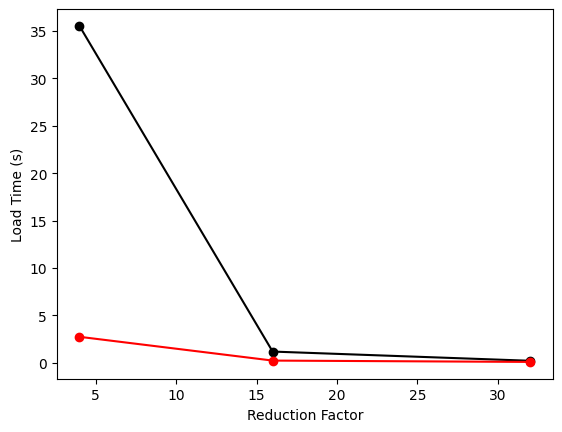

In [11]:
reduction_factor = slide.level_downsamples[1:4]

plt.plot(reduction_factor,times, '-ok')
plt.plot(reduction_factor,cu_times, '-or')
plt.xlabel("Reduction Factor")
plt.ylabel("Load Time (s)");

plt.show

So, you should notice that CuCIM is about an order of magnitude faster at loading the image data.

cuCIM includes a feature (since v21.12.1) that actually uses multiple threads internally to load an image. This is a much more efficient and cleaner way of quickly loading an image. It requires no Python GIL workarounds and uses far fewer resources. Let's compare it with our Python implementation.

Please note that we are loading a very large image and so there is a chance that we will run out of RAM when loading this image. If this happens you will most likely see an error message pop up telling you that the kernel just re-launched. If this happens, it will actually remove all the current data from RAM from the previous cells and it will probably work if you try again (No need to re-run any previous cells).

In [27]:
%%time
from cucim import CuImage

input_file = "data/tcga1.svs"
sizes=wsi.metadata["cucim"]["resolutions"]
width = sizes["level_dimensions"][0][0]
height = sizes["level_dimensions"][0][1]
img = wsi.read_region((0,0),(width, height), 0, num_workers=16)
print(img.shape)

[52434, 87647, 3]
CPU times: user 34.4 s, sys: 15.8 s, total: 50.2 s
Wall time: 3.87 s


Now we can try loading the image with OpenSlide but use different threads to load different parts of the image. Although the run time is significantly slower than cuCIM, this is not a particularly fair comparison since in this simplistic code, there was no ability to actually assign the sub regions loaded into a single global array.

In [14]:
%%time
import threading
import time

# You can also try changing the number of threads and see what effect
# it has on the overall run time
num_threads = 16
level = 0

class loaderThread (threading.Thread):
    def __init__(self, threadID):
        # Class initialisation - set its ID
        threading.Thread.__init__(self)
        self.threadID = threadID

    def run(self):
        print("Starting thread {}".format(self.threadID))
        start = timer()
        width, height = slide.level_dimensions[level]
        x = (width // num_threads) * (1-self.threadID)
        img = slide.read_region((x,0), level,(width//num_threads, height))
        end = timer()
        print("Exiting thread {}, running time = {}".format(self.threadID, str(end-start)))

threads = []

for i in range(num_threads):
    # Create new threads
    thread = loaderThread(i)
    thread.start()
    threads.append(thread)

# Wait for all threads to complete
for t in threads:
    t.join()
    
print("Exiting Main Thread")

Starting thread 0
Starting thread 1
Starting thread 2
Starting thread 3
Starting thread 4
Exiting thread 2, running time = 1.7584202568978071
Starting thread 5
Exiting thread 3, running time = 1.89818179118447
Starting thread 6
Exiting thread 4, running time = 1.982367997057736
Starting thread 7
Starting thread 8
Starting thread 9
Starting thread 10
Exiting thread 5, running time = 1.975140712922439
Starting thread 11
Exiting thread 7, running time = 3.1563069061376154
Exiting thread 6, running time = 3.887849658029154
Starting thread 12
Starting thread 13
Exiting thread 8, running time = 3.8995528689119965
Exiting thread 9, running time = 3.9611317559611052
Exiting thread 10, running time = 4.021413882030174
Starting thread 14
Starting thread 15
Exiting thread 12, running time = 2.5927540860138834
Exiting thread 11, running time = 3.540490410057828
Exiting thread 14, running time = 2.235539502929896
Exiting thread 13, running time = 2.4680307400412858
Exiting thread 15, running time =

In [22]:
del(img)

So, cuCIM has loaded the whole image in a much shorter time because it is using multiple threads to load the data concurrently and because this is happening at C++ layer, there is no GIL problem to slow things down. You can also see that the output reports the total CPU time as ~50 seconds - which is how long it might have taken using a single thread.

What is also useful is that although it uses concurrent threads to load separate regions, it stitches them all together into one array

N.B. you may have to restart the kernel if you run out of memory. Alternatively you could load the image at a reduction level of 1 

This section should have given you a good grasp of how much of a difference the combination of a decent image loader and some threading or multi-processing can make.

You can now close this notebook and open Notebook_2 to find out how to use a different technique to load images. 